In [79]:
import sklearn as sk
import sklearn.preprocessing as skp
from sklearn import linear_model
from sklearn import ensemble
from sklearn import preprocessing
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [80]:
train = pd.read_csv('data/train.csv')

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [82]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [84]:
def adjust_data(df):
    df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    df.Cabin.fillna('N',inplace=True)
    df["CabinType"] = df.Cabin.apply(lambda x: x[0])

    df["TicketType"] = df.Ticket.apply(lambda x: x[0:3])
    df['TicketType'] = df['TicketType'].astype('category')
    df['TicketType'] = df['TicketType'].cat.codes
    df["TicketNumber"] = df.Ticket.apply(lambda x: x if x.find(" ")!=-1 else " "+x ).apply(lambda x: x.replace(".","").split(' ')[1] )
    df.TicketNumber.replace('LINE',0,inplace=True)
    df.TicketNumber.replace('Basle',1,inplace=True)
    df.TicketNumber = df.TicketNumber.astype(int) 

    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)
    df['CategoricalAge'] = pd.cut(df['Age'], 5)
    df.CategoricalAge = df.CategoricalAge.astype('str')

    df['Embarked'] = df['Embarked'].fillna('S')

    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['CategoricalFare'] = pd.qcut(df['Fare'], 4)
    df.CategoricalFare = df.CategoricalFare.astype('str')

    df['Words_Count'] = df['Name'].apply(lambda x: len(x.split()))
    df['Title'] = df['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"

    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [85]:
adjust_data(train)

C:\Users\omarg\AppData\Local\Temp\ipykernel_15320\4091812063.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'][np.isnan(df['Age'])] = age_null_random_list


In [86]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,CabinType,TicketType,TicketNumber,CategoricalAge,CategoricalFare,Words_Count,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,N,S,0,N,124,21171,"(16.0, 32.0]","(-0.001, 7.91]",4,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,C,137,17599,"(32.0, 48.0]","(31.0, 512.329]",7,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,N,S,0,N,148,3101282,"(16.0, 32.0]","(7.91, 14.454]",3,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,C,3,113803,"(32.0, 48.0]","(31.0, 512.329]",7,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,N,S,0,N,97,373450,"(32.0, 48.0]","(7.91, 14.454]",4,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,N,S,0,N,23,211536,"(16.0, 32.0]","(7.91, 14.454]",3,Rare
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,1,B,2,112053,"(16.0, 32.0]","(14.454, 31.0]",4,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22,1,2,W./C. 6607,23.4500,N,S,0,N,150,6607,"(16.0, 32.0]","(14.454, 31.0]",5,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,1,C,1,111369,"(16.0, 32.0]","(14.454, 31.0]",4,Mr


In [87]:

def plotDistribution(df,features,titles=[]):
    size = len(features)
    rows = math.ceil(size/2)
    plt.figure(figsize=(15,10))
    for i,feature in enumerate(features):  
        a = df.groupby(feature).count().PassengerId
        plt.subplot(rows,2,i+1)
        plt.bar(a.index,a)
        plt.title(titles[i] or "")
    plt.tight_layout()
    plt.show()

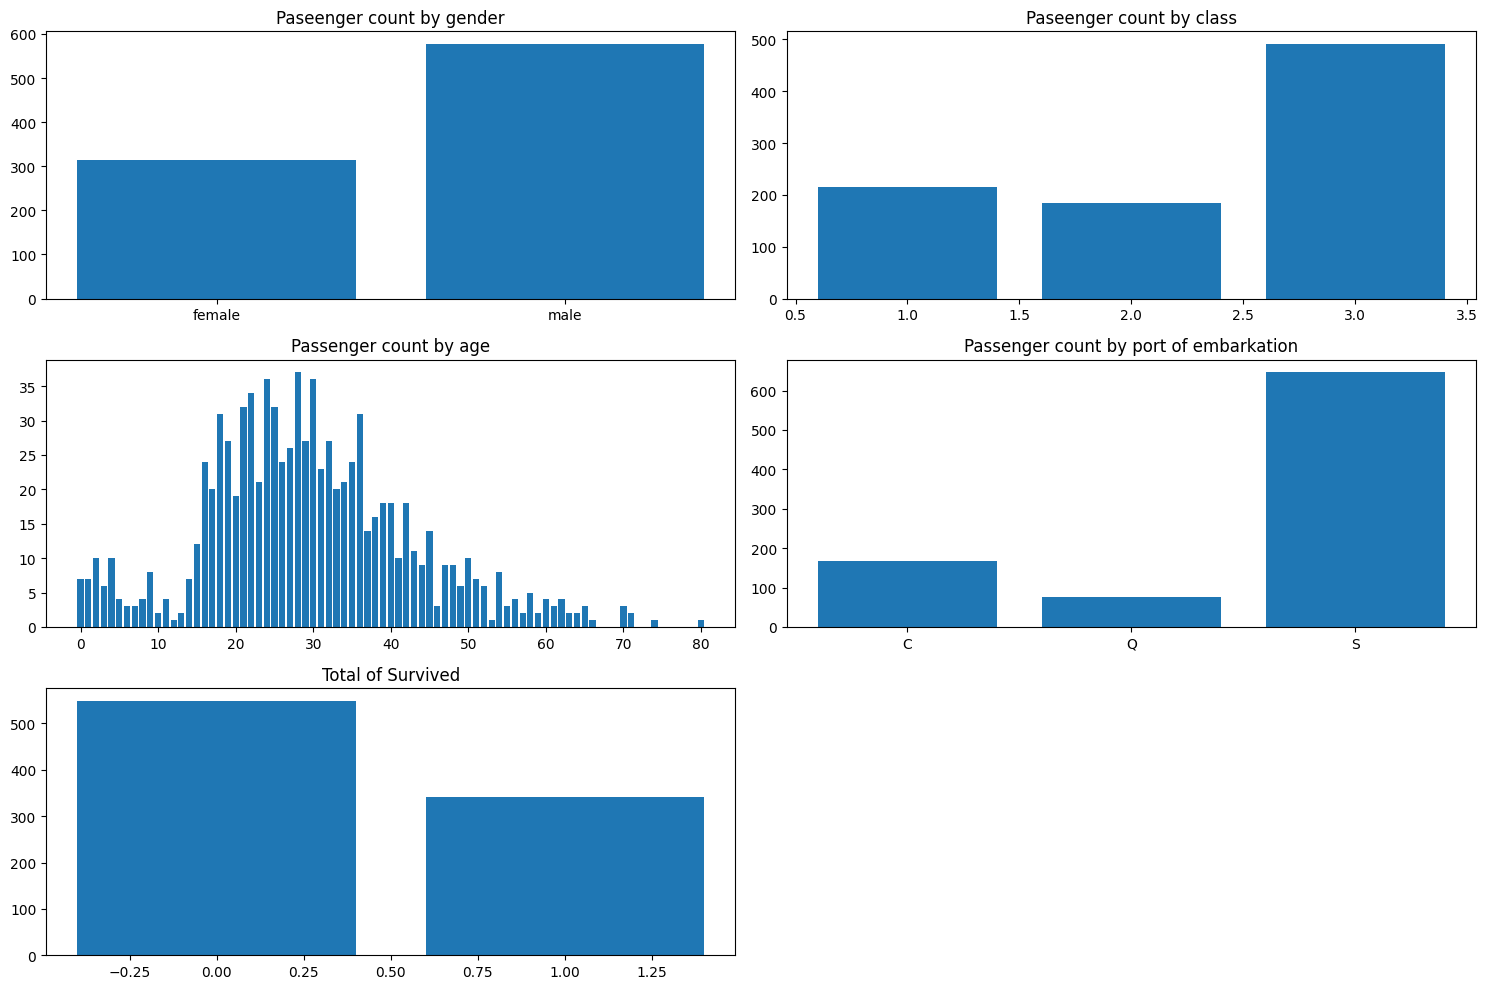

In [88]:
titles = ["Paseenger count by gender","Paseenger count by class","Passenger count by age","Passenger count by port of embarkation","Total of Survived"]
plotDistribution(train,["Sex","Pclass","Age","Embarked","Survived"],titles)

<Axes: title={'center': 'Survived'}, xlabel='Survived'>

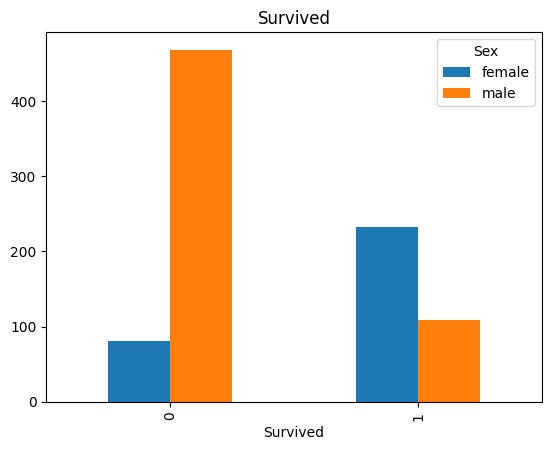

In [89]:
train.groupby(["Survived","Sex"]).count().unstack().PassengerId.plot(kind="bar",title="Survived")

<Axes: title={'center': 'Survived'}, xlabel='Survived'>

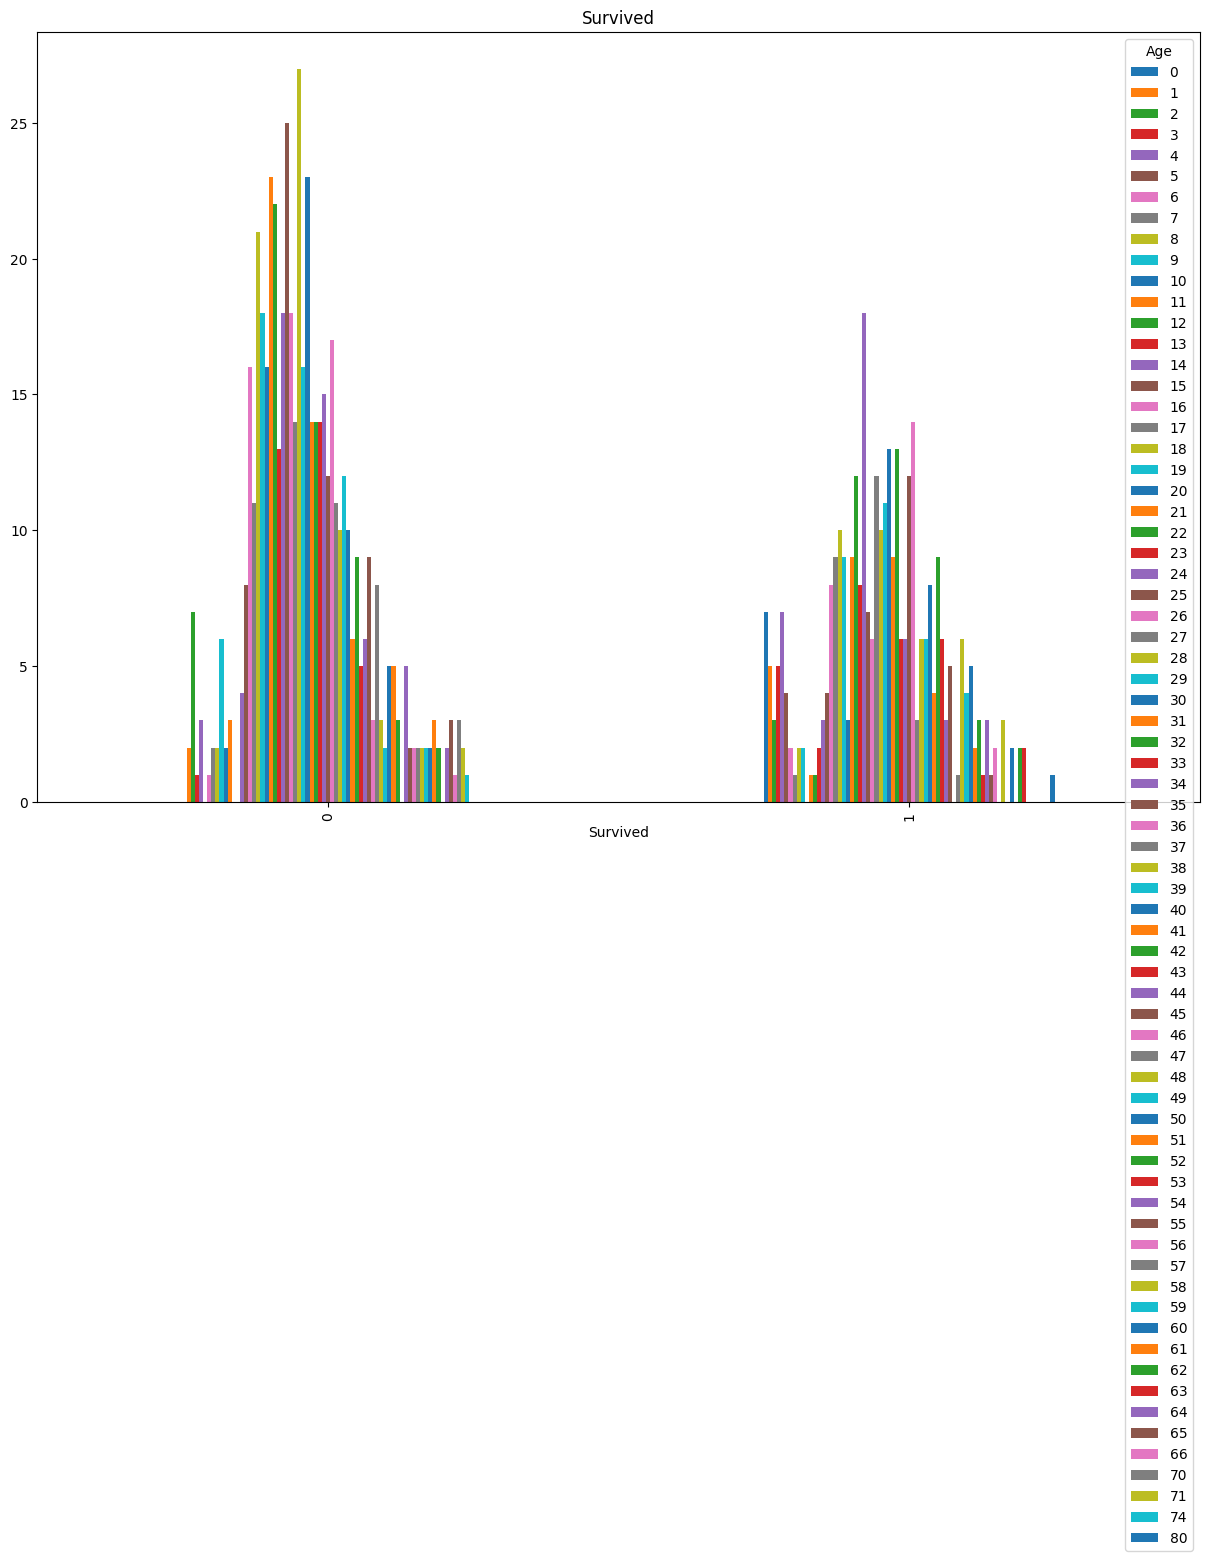

In [90]:
train.groupby(["Survived","Age"]).count().unstack().PassengerId.plot(kind="bar",title="Survived", figsize=(15,10))

<Axes: title={'center': 'Survived'}, xlabel='Survived'>

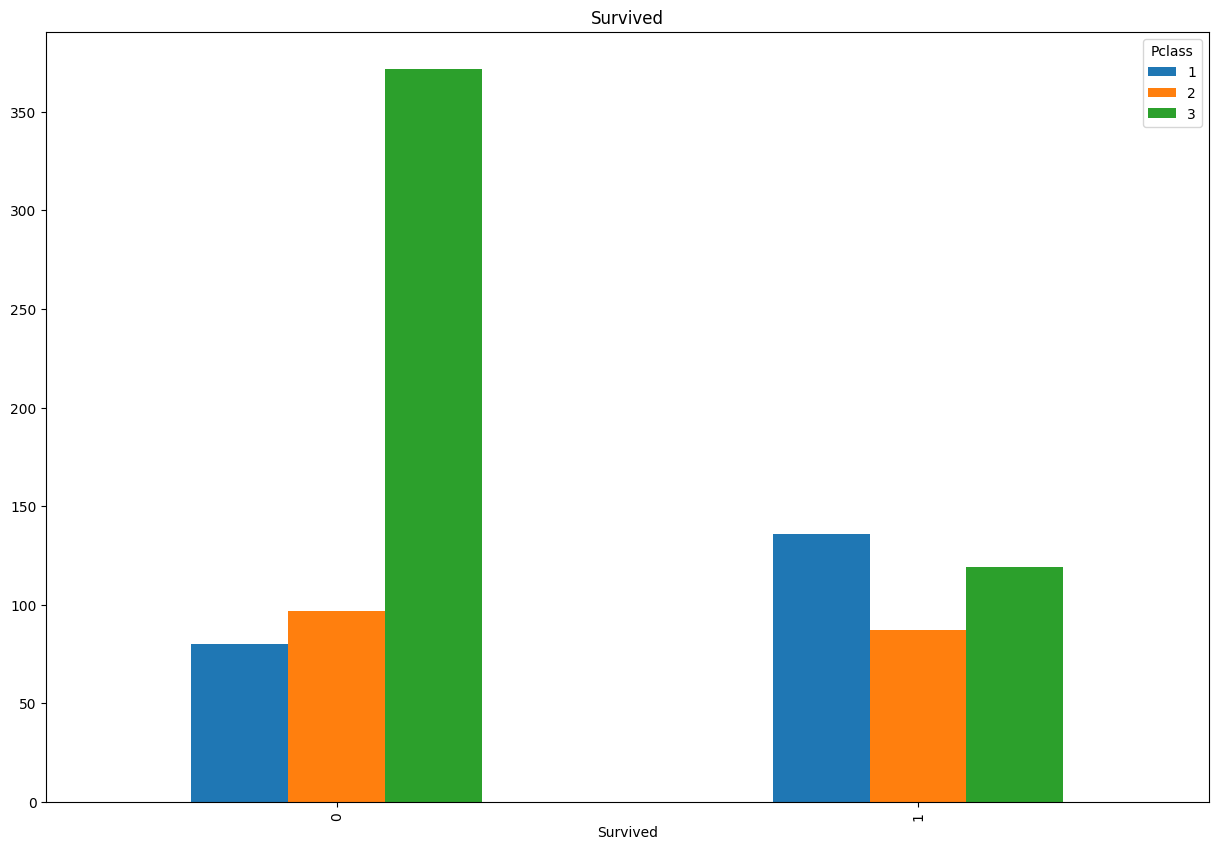

In [91]:
train.groupby(["Survived","Pclass"]).count().unstack().PassengerId.plot(kind="bar",title="Survived", figsize=(15,10))

<Axes: title={'center': 'Survived'}, xlabel='Survived'>

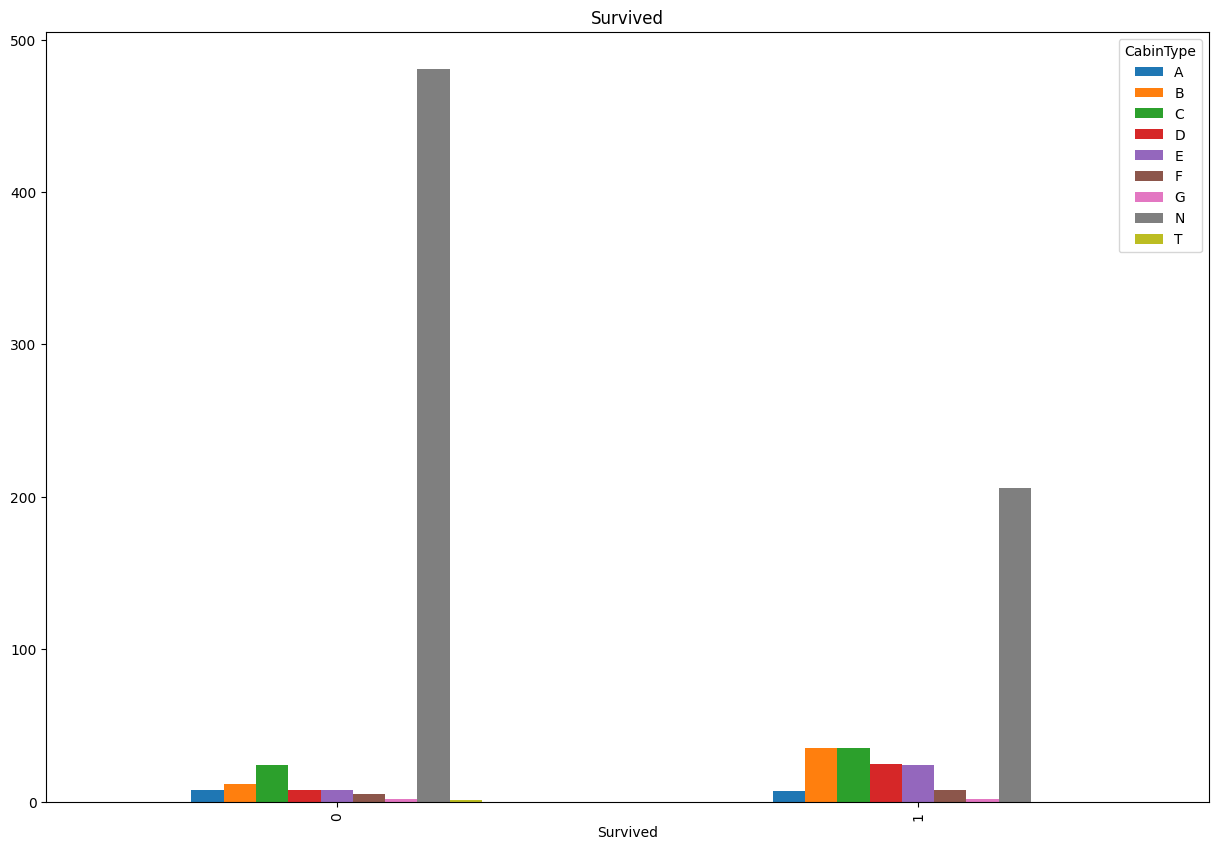

In [92]:
train.groupby(["Survived","CabinType"]).count().unstack().PassengerId.plot(kind="bar",title="Survived", figsize=(15,10))

In [93]:
def convert_to_categorical(df,feature):
    values = df[feature].unique()
    for i,v in enumerate(values):
        finded = df[df[feature]==v]
        # finded[feature] = i
        df.loc[finded.index,feature] = i


In [94]:
def prepare_data(df):
    # df = pd.get_dummies(df, columns=['Sex'])
    # df = pd.get_dummies(df, columns=['Embarked'])
    # df = pd.get_dummies(df, columns=['Cabin'])
    # df = pd.get_dummies(df, columns=['Pclass'])
    convert_to_categorical(df,"Sex")
    convert_to_categorical(df,"Embarked")
    convert_to_categorical(df,"Pclass")
    convert_to_categorical(df,"Title")
    convert_to_categorical(df,"CategoricalAge")
    convert_to_categorical(df,"CategoricalFare")
    convert_to_categorical(df,"CabinType")
    convert_to_categorical(df,'TicketType')

    df["PartOfFamily"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = df["PartOfFamily"] == 0
    df.drop(["SibSp"],axis=1,inplace=True)
    
    return df


In [95]:
train = prepare_data(train)

In [96]:
train.drop(["Name","PassengerId","Ticket","Cabin"],axis=1)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,CabinType,TicketType,TicketNumber,CategoricalAge,CategoricalFare,Words_Count,Title,PartOfFamily,IsAlone
0,0,0,0,22,0,7.2500,0,0,0,107,21171,0,0,4,0,1,False
1,1,1,1,38,0,71.2833,1,1,1,72,17599,1,1,7,1,1,False
2,1,0,1,26,0,7.9250,0,0,0,81,3101282,0,2,3,2,0,True
3,1,1,1,35,0,53.1000,0,1,1,3,113803,1,1,7,1,1,False
4,0,0,0,35,0,8.0500,0,0,0,135,373450,1,2,4,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,13.0000,0,0,0,153,211536,0,2,3,4,0,True
887,1,1,1,19,0,30.0000,0,1,6,81,112053,0,3,4,2,0,True
888,0,0,1,22,2,23.4500,0,0,0,47,6607,0,3,5,2,3,False
889,1,1,0,26,0,30.0000,1,1,1,72,111369,0,3,4,0,0,True


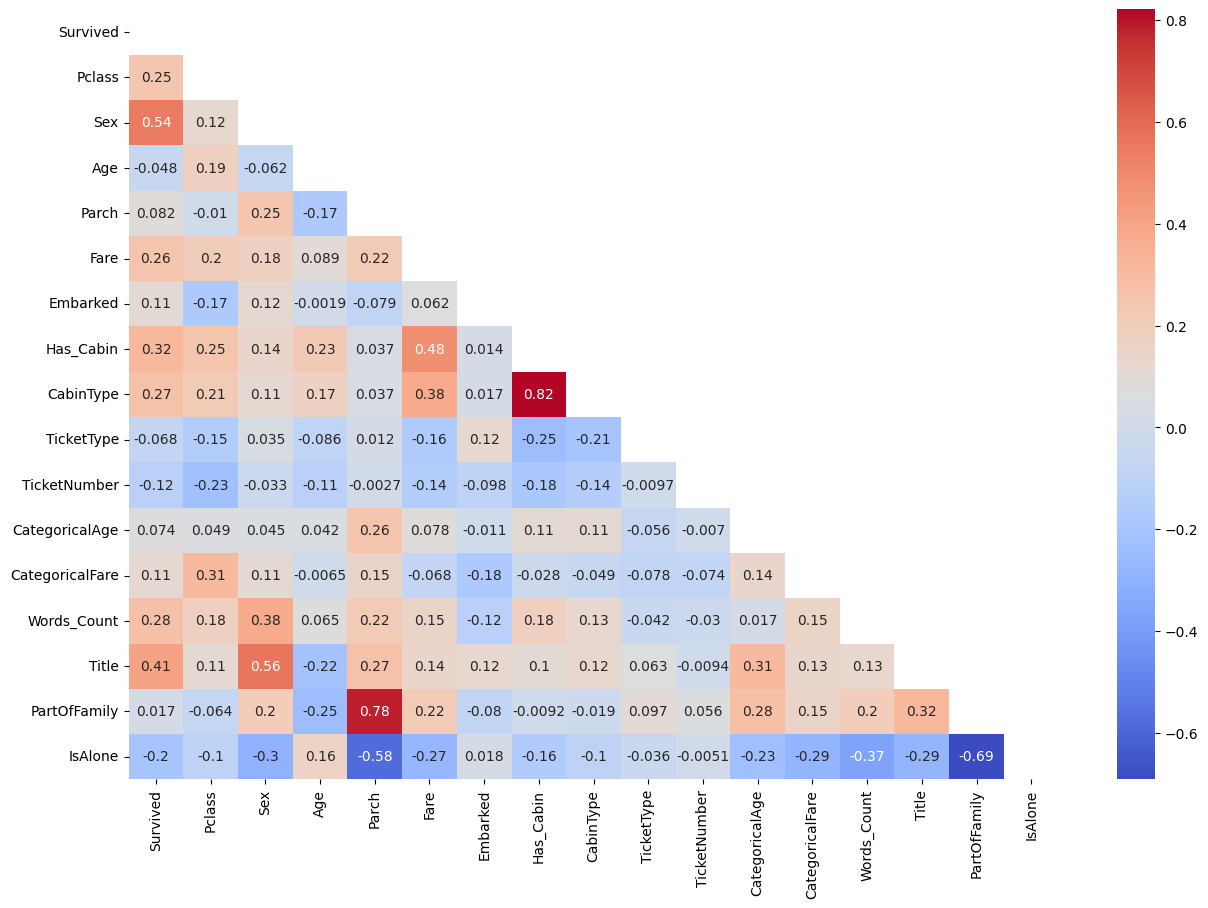

In [97]:
# Calcular la matriz de correlación
# ticket_cols = [col for col in train.columns if col.find("TicketType") != -1]
# cabin_cols = [col for col in train.columns if col.find("Cabin") != -1]
corr_matrix = train.drop(["Name","PassengerId","Ticket","Cabin"],axis=1).corr()

# Crear una máscara booleana para la parte superior de la matriz
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear un mapa de calor
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',mask=mask)

# Mostrar el gráfico
plt.show()

In [98]:
train.drop(["Name","PassengerId","Ticket",'Cabin'],axis=1)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,CabinType,TicketType,TicketNumber,CategoricalAge,CategoricalFare,Words_Count,Title,PartOfFamily,IsAlone
0,0,0,0,22,0,7.2500,0,0,0,107,21171,0,0,4,0,1,False
1,1,1,1,38,0,71.2833,1,1,1,72,17599,1,1,7,1,1,False
2,1,0,1,26,0,7.9250,0,0,0,81,3101282,0,2,3,2,0,True
3,1,1,1,35,0,53.1000,0,1,1,3,113803,1,1,7,1,1,False
4,0,0,0,35,0,8.0500,0,0,0,135,373450,1,2,4,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,13.0000,0,0,0,153,211536,0,2,3,4,0,True
887,1,1,1,19,0,30.0000,0,1,6,81,112053,0,3,4,2,0,True
888,0,0,1,22,2,23.4500,0,0,0,47,6607,0,3,5,2,3,False
889,1,1,0,26,0,30.0000,1,1,1,72,111369,0,3,4,0,0,True


In [99]:
train.drop(["Name","PassengerId","Ticket",'Cabin'],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Survived         891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Sex              891 non-null    object 
 3   Age              891 non-null    int32  
 4   Parch            891 non-null    int64  
 5   Fare             891 non-null    float64
 6   Embarked         891 non-null    object 
 7   Has_Cabin        891 non-null    int64  
 8   CabinType        891 non-null    object 
 9   TicketType       891 non-null    int16  
 10  TicketNumber     891 non-null    int32  
 11  CategoricalAge   891 non-null    object 
 12  CategoricalFare  891 non-null    object 
 13  Words_Count      891 non-null    int64  
 14  Title            891 non-null    object 
 15  PartOfFamily     891 non-null    int64  
 16  IsAlone          891 non-null    bool   
dtypes: bool(1), floa

In [100]:
features = ["Name","PassengerId","Ticket",'Cabin','Age','TicketNumber','Fare']
X,Y = train.drop(["Survived",*features],axis=1),train.Survived
# Ajustar y transformar la columna 'column_name'

X,Y = X.fillna(0),Y.fillna(0)
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,Y)

In [101]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Pclass           891 non-null    int64
 1   Sex              891 non-null    int64
 2   Parch            891 non-null    int64
 3   Embarked         891 non-null    int64
 4   Has_Cabin        891 non-null    int64
 5   CabinType        891 non-null    int64
 6   TicketType       891 non-null    int16
 7   CategoricalAge   891 non-null    int64
 8   CategoricalFare  891 non-null    int64
 9   Words_Count      891 non-null    int64
 10  Title            891 non-null    int64
 11  PartOfFamily     891 non-null    int64
 12  IsAlone          891 non-null    bool 
dtypes: bool(1), int16(1), int64(11)
memory usage: 79.3 KB


In [102]:
ridge = linear_model.RidgeClassifier()
res = ridge.fit(X_train,y_train)
res.score(X_test,y_test)

0.7488789237668162

In [103]:
ridgeCV = linear_model.RidgeClassifierCV()
res = ridgeCV.fit(X_train,y_train)
res.score(X_test,y_test)

0.7488789237668162

In [104]:
rand_forest = ensemble.RandomForestClassifier()
res = rand_forest.fit(X_train,y_train)
res.score(X_test,y_test)

0.8026905829596412

In [105]:
xb_boost = xgb.XGBClassifier()
xg_boost = xb_boost.fit(X_train,y_train)
xg_boost.score(X_test,y_test)

0.7802690582959642

In [106]:
from sklearn import model_selection


xb_boost2 = xgb.XGBClassifier()
xg_CV = model_selection.cross_val_score(xb_boost2,X,Y,cv=5)
print(xg_CV)

[0.76536313 0.82022472 0.80337079 0.80337079 0.82022472]


In [120]:
votes = ensemble.VotingClassifier(estimators=[('rd',ensemble.RandomForestClassifier()),('xgb',xgb.XGBClassifier())])
votes.fit(X,Y)
votes.score(X,Y)

0.9708193041526375

In [108]:
test = pd.read_csv('./data/test.csv')

In [109]:
adjust_data(test)
test = prepare_data(test)

C:\Users\omarg\AppData\Local\Temp\ipykernel_15320\4091812063.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'][np.isnan(df['Age'])] = age_null_random_list


In [110]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,CabinType,TicketType,TicketNumber,CategoricalAge,CategoricalFare,Words_Count,Title,PartOfFamily,IsAlone
0,892,0,"Kelly, Mr. James",0,34,0,330911,7.8292,N,0,0,0,72,330911,0,0,3,0,0,True
1,893,0,"Wilkes, Mrs. James (Ellen Needs)",1,47,0,363272,7.0000,N,1,0,0,85,363272,1,0,5,1,1,False
2,894,2,"Myles, Mr. Thomas Francis",0,62,0,240276,9.6875,N,0,0,0,95,240276,2,1,4,0,0,True
3,895,0,"Wirz, Mr. Albert",0,27,0,315154,8.6625,N,1,0,0,65,315154,3,1,3,0,0,True
4,896,0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22,1,3101298,12.2875,N,1,0,0,81,3101298,3,1,6,1,2,False


In [111]:
test.Sex = test.Sex.astype('int8')
test.Embarked = test.Embarked.astype('int8')
test.CabinType = test.CabinType.astype('int8')
test.TicketType = test.TicketType.astype('int8')
test.CategoricalAge = test.CategoricalAge.astype('int8')
test.CategoricalFare = test.CategoricalFare.astype('int8')
test.Title = test.Title.astype('int8')
test.drop(features,axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Pclass           418 non-null    int64
 1   Sex              418 non-null    int8 
 2   Parch            418 non-null    int64
 3   Embarked         418 non-null    int8 
 4   Has_Cabin        418 non-null    int64
 5   CabinType        418 non-null    int8 
 6   TicketType       418 non-null    int8 
 7   CategoricalAge   418 non-null    int8 
 8   CategoricalFare  418 non-null    int8 
 9   Words_Count      418 non-null    int64
 10  Title            418 non-null    int8 
 11  PartOfFamily     418 non-null    int64
 12  IsAlone          418 non-null    bool 
dtypes: bool(1), int64(5), int8(7)
memory usage: 19.7 KB


In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Pclass           418 non-null    int64  
 2   Name             418 non-null    object 
 3   Sex              418 non-null    int8   
 4   Age              418 non-null    int32  
 5   Parch            418 non-null    int64  
 6   Ticket           418 non-null    object 
 7   Fare             418 non-null    float64
 8   Cabin            418 non-null    object 
 9   Embarked         418 non-null    int8   
 10  Has_Cabin        418 non-null    int64  
 11  CabinType        418 non-null    int8   
 12  TicketType       418 non-null    int8   
 13  TicketNumber     418 non-null    int32  
 14  CategoricalAge   418 non-null    int8   
 15  CategoricalFare  418 non-null    int8   
 16  Words_Count      418 non-null    int64  
 17  Title           

In [113]:
res = votes.predict(test.drop(features,axis=1))

In [114]:
res

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,

In [115]:
submition = pd.DataFrame()
submition["PassengerId"] = test.PassengerId
submition["Survived"] = res

In [116]:
submition

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,1
416,1308,0


In [117]:
submition.to_csv('./submition.csv',index=False)